In [69]:
import geopandas as gpd
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.dates as mdates
import numpy as np
import glob
import os
import xlwt
import openpyxl
import rasterio
from astropy.convolution import convolve, convolve_fft

#root = 'C:/Users/mathi/My Drive (thesis20212022@gmail.com)'
root = 'C:/Users/Rasmus/Mit drev (thesis20212022@gmail.com)'
all_files = glob.glob(root + '/Validation/SeNorgeCSVs/*.csv')

# Sample heights from DEM into station shapefile
DEM = root + r'\Norway\DEM/mergedDEM10_All_Norway.tif'
stations = gpd.read_file(root + '/Validation/StationShapefiles/InSituStations.shp')

coords = [(x,y) for x, y in zip(stations.geometry.x, stations.geometry.y)]
src = rasterio.open(DEM)
stations['DEM'] = [x[0] for x in src.sample(coords)]

stations

,id,Stasjon,Elevation,Name,geometry,DEM
0,0,SN40880,843,Hovden - Lundane,POINT (70498.279 6628657.259),841.536865
1,0,SN40905,988,Rv9 Hovden,POINT (75218.855 6635586.552),914.637268
2,0,SN33950,986,Haukeliseter Testfelt,POINT (64054.684 6655966.951),985.607849
3,0,SN46430,997,Røldalsfjellet,POINT (37357.270 6661558.671),997.143982
4,0,SN29400,1247,Sandhaug,POINT (83510.005 6695603.580),1246.882690
5,0,SN31620,973,Møsstrand Ii,POINT (118122.768 6653243.171),973.284302
6,0,SN31520,970,Groset,POINT (125685.036 6652008.750),950.889648
7,0,SN31660,952,Mogen,POINT (105453.044 6674537.408),951.679077
8,0,SN49860,1231,Rv7 Dyranut,POINT (86674.119 6716074.395),1231.110229
9,0,SN29900,1247,Skurdevikåi,POINT (90912.526 6716563.445),1247.499268


In [70]:
#station_obs = pd.read_excel(root + '/Validation/StationXLS/StationObservations2.xls')
station_obs = pd.read_excel(root + '/Validation/StationXLS/StationObservations_temp&SD.xls')

# Set station name
stationsnavn = 'Haukeliseter Testfelt'

# Set start and end date of interest - format: yyyy-mm-dd
startdate = '2022-01-01'
enddate = '2022-04-30'

# Get df with only of unique station names and IDs
unique = station_obs.drop_duplicates(subset=['Navn'])
#unique = unique.drop(columns=['Tid(norsk normaltid)','Snødybde'])
unique = unique.drop(columns=['Tid(norsk normaltid)','Snødybde','Middeltemperatur (døgn)'])

unique.sort_values(by=['Stasjon'], ascending=True)

,Navn,Stasjon
11390,Øvre Heimdalsvatn,SN13750
10686,Fv51 Valdresflye,SN13760
14287,Juvvasshøe,SN15270
15364,Rv15 Breidalen,SN15950
12223,Høvringen Ii,SN16271
13299,Fokstugu,SN16610
9609,Beitostølen Ii,SN23550
6426,Finsevatn,SN25830
4037,Sandhaug,SN29400
5937,Skurdevikåi,SN29900


In [71]:
### Preparing station data

# Filter by station name
station_obs = station_obs.loc[station_obs['Navn'] == stationsnavn]

# Filter by date interval
station_obs = station_obs.rename(columns={'Tid(norsk normaltid)':'Tid','Snødybde':'SD_Station'})
station_obs['Tid'] = pd.to_datetime(station_obs['Tid'], format='%d.%m.%Y')
station_obs = station_obs[(station_obs['Tid'] > startdate) & (station_obs['Tid'] < enddate)]

station_obs

,Navn,Stasjon,Tid,Middeltemperatur (døgn),SD_Station
2835,Haukeliseter Testfelt,SN33950,2022-01-02,1.3,25
2836,Haukeliseter Testfelt,SN33950,2022-01-03,-1.7,28
2837,Haukeliseter Testfelt,SN33950,2022-01-04,-4.6,36
2838,Haukeliseter Testfelt,SN33950,2022-01-05,-7,46
2839,Haukeliseter Testfelt,SN33950,2022-01-06,-12.2,46
...,...,...,...,...,...
2948,Haukeliseter Testfelt,SN33950,2022-04-26,0.9,68
2949,Haukeliseter Testfelt,SN33950,2022-04-27,1.2,67
2950,Haukeliseter Testfelt,SN33950,2022-04-28,-0.2,66
2951,Haukeliseter Testfelt,SN33950,2022-04-29,0.1,66


In [72]:
### Preparing first-hand observation data

firsthand_obs = pd.read_excel(root + '/Validation/FirsthandObsAverage_Stations.xls')

firsthand_obs = firsthand_obs.loc[firsthand_obs['Station'] == stationsnavn]

firsthand_obs['Tid'] = pd.to_datetime(firsthand_obs['Date'], format='%d.%m.%Y')

firsthand_obs

,SD,Date,Station,Tid
2,226,24.02.2022,Haukeliseter Testfelt,2022-02-24


In [73]:
### Preparing SeNorge data

# Read SeNorge .csv files and put in a list for dataframe concatenation
li = []
for csv in all_files:
    df = pd.read_csv(csv, index_col=None, header=1, delimiter=';')
    df['Navn'] = os.path.basename(csv).split('.')[0]
    li.append(df)
senorge_pred = pd.concat(li, axis=0, ignore_index=True)
print(unique.sort_values(by=['Stasjon'], ascending=True))
# Filter by station name
senorge_pred = senorge_pred.loc[senorge_pred['Navn'] == stationsnavn]
senorge_pred = senorge_pred.drop(columns=['Navn'])

# Filter by date interval
senorge_pred = senorge_pred.rename(columns={'Date':'Tid'})
senorge_pred['Tid'] = senorge_pred['Tid'].str.slice(0,10)
senorge_pred['Tid'] = pd.to_datetime(senorge_pred['Tid'], format='%d.%m.%Y')
senorge_pred = senorge_pred[(senorge_pred['Tid'] > startdate) & (senorge_pred['Tid'] < enddate)]

# Filter out invalid observation
senorge_pred = senorge_pred.rename(columns={'sd(cm)': 'SD_SeNorge'})
senorge_pred = senorge_pred.loc[senorge_pred['SD_SeNorge'] != 65535.0]

#senorge_pred

                            Navn  Stasjon
11390          Øvre Heimdalsvatn  SN13750
10686           Fv51 Valdresflye  SN13760
14287                 Juvvasshøe  SN15270
15364             Rv15 Breidalen  SN15950
12223               Høvringen Ii  SN16271
13299                   Fokstugu  SN16610
9609              Beitostølen Ii  SN23550
6426                   Finsevatn  SN25830
4037                    Sandhaug  SN29400
5937                 Skurdevikåi  SN29900
1906       Haukeliseter Testfelt  SN33950
0               Hovden - Lundane  SN40880
1075                  Rv9 Hovden  SN40905
2968              Røldalsfjellet  SN46430
5111                 Rv7 Dyranut  SN49860
17063             Rv13 Vikafjell  SN53010
7461                   Midtstova  SN53530
8533   Filefjell - Kyrkjestølane  SN54710
16156                     Mannen  SN61410


In [74]:
### Combine dataframes

merged_df = pd.merge(station_obs, senorge_pred, on='Tid', how='right')

# Filter out observations with 0 SD in both columns
merged_df = merged_df.loc[(merged_df['SD_Station'] !=0) | merged_df['SD_SeNorge'] !=0]

merged_df

,Navn,Stasjon,Tid,Middeltemperatur (døgn),SD_Station,SD_SeNorge
0,Haukeliseter Testfelt,SN33950,2022-01-02,1.3,25,100.0
1,Haukeliseter Testfelt,SN33950,2022-01-03,-1.7,28,98.4
2,Haukeliseter Testfelt,SN33950,2022-01-04,-4.6,36,113.8
3,Haukeliseter Testfelt,SN33950,2022-01-05,-7,46,114.1
4,Haukeliseter Testfelt,SN33950,2022-01-06,-12.2,46,112.2
...,...,...,...,...,...,...
113,Haukeliseter Testfelt,SN33950,2022-04-25,1.3,70,245.3
114,Haukeliseter Testfelt,SN33950,2022-04-26,0.9,68,243.0
115,Haukeliseter Testfelt,SN33950,2022-04-27,1.2,67,240.5
116,Haukeliseter Testfelt,SN33950,2022-04-28,-0.2,66,239.7


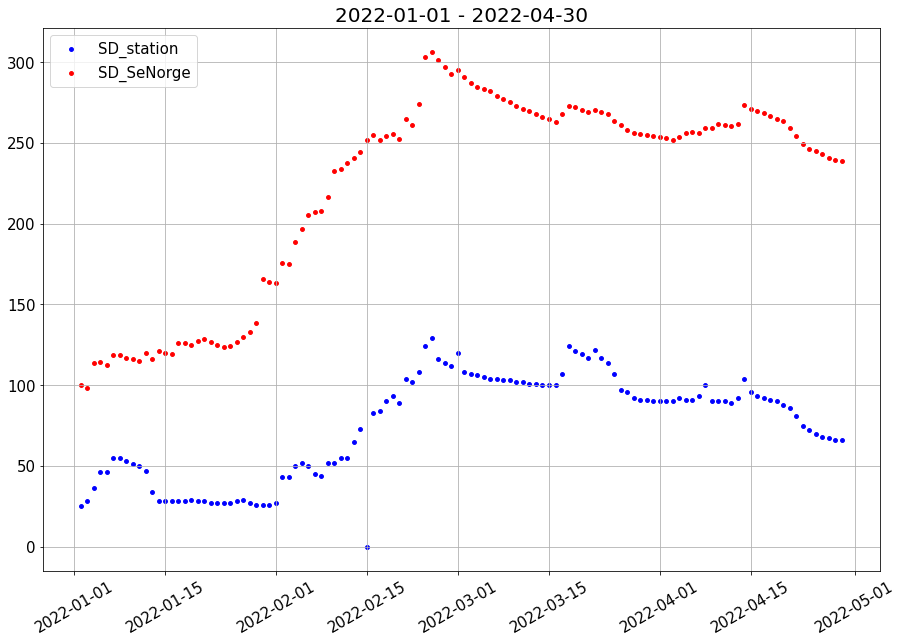

In [75]:
# Create template and choose window size
plt.figure(figsize = (15, 10))

# Generate title based on entered dates
plt.title(startdate +' - ' + enddate, fontsize=20)

# Configure x-axis date labels
plt.xticks(rotation=30, fontsize=15)
myFmt = mdates.DateFormatter('%Y-%m-%d')
plt.gca().xaxis.set_major_formatter(myFmt)

# Configure y-axis labels
plt.yticks(fontsize = 15)

# Show grid
plt.grid(True)

# Generate plot
plt.scatter(merged_df.Tid, merged_df.SD_Station, color='blue', s=15, label='SD_station')
plt.scatter(merged_df.Tid, merged_df.SD_SeNorge, color='red', s=15, label='SD_SeNorge')
plt.legend(loc='upper left', prop={'size': 15})

In [76]:
merged_df

,Navn,Stasjon,Tid,Middeltemperatur (døgn),SD_Station,SD_SeNorge
0,Haukeliseter Testfelt,SN33950,2022-01-02,1.3,25,100.0
1,Haukeliseter Testfelt,SN33950,2022-01-03,-1.7,28,98.4
2,Haukeliseter Testfelt,SN33950,2022-01-04,-4.6,36,113.8
3,Haukeliseter Testfelt,SN33950,2022-01-05,-7,46,114.1
4,Haukeliseter Testfelt,SN33950,2022-01-06,-12.2,46,112.2
...,...,...,...,...,...,...
113,Haukeliseter Testfelt,SN33950,2022-04-25,1.3,70,245.3
114,Haukeliseter Testfelt,SN33950,2022-04-26,0.9,68,243.0
115,Haukeliseter Testfelt,SN33950,2022-04-27,1.2,67,240.5
116,Haukeliseter Testfelt,SN33950,2022-04-28,-0.2,66,239.7


In [77]:
stations_sampled = gpd.read_file(root + '/Validation/StationShapefiles/InSituStations_sampled_2.shp')

In [78]:
stations_sampled = stations_sampled .loc[stations_sampled ['Name'] == stationsnavn]

stations_sampled = stations_sampled[stations_sampled['SD_Model'] > 0]
stations_sampled['SD_Model'] = stations_sampled['SD_Model'] * 100

stations_sampled['Sample_Dat'] = pd.to_datetime(stations_sampled['Sample_Dat'], format='%Y-%m-%d')

stations_sampled

,id,Stasjon,Elevation,Name,SD_Model,Sample_Dat,geometry
48,0,SN33950,986,Haukeliseter Testfelt,86.485959,2020-01-15,POINT (64326.225 6656127.407)
94,0,SN33950,986,Haukeliseter Testfelt,59.464019,2020-02-02,POINT (64326.225 6656127.407)
117,0,SN33950,986,Haukeliseter Testfelt,112.254651,2020-02-08,POINT (64326.225 6656127.407)
140,0,SN33950,986,Haukeliseter Testfelt,116.980690,2020-02-14,POINT (64326.225 6656127.407)
163,0,SN33950,986,Haukeliseter Testfelt,156.609556,2020-02-20,POINT (64326.225 6656127.407)
186,0,SN33950,986,Haukeliseter Testfelt,184.991384,2020-02-26,POINT (64326.225 6656127.407)
209,0,SN33950,986,Haukeliseter Testfelt,184.243952,2020-03-03,POINT (64326.225 6656127.407)
232,0,SN33950,986,Haukeliseter Testfelt,197.924684,2020-03-09,POINT (64326.225 6656127.407)
255,0,SN33950,986,Haukeliseter Testfelt,205.529129,2020-03-15,POINT (64326.225 6656127.407)
278,0,SN33950,986,Haukeliseter Testfelt,228.174373,2020-03-21,POINT (64326.225 6656127.407)


In [79]:
mergedf2 = merged_df.merge(stations_sampled, left_on = "Tid", right_on = "Sample_Dat", how = "left")

In [80]:
from astropy.convolution import Gaussian1DKernel
gauss_1D_kernel = Gaussian1DKernel(5)
#kernel_size = 111
#kernel = np.ones(kernel_size) / kernel_size
mergedf2.loc[mergedf2['SD_Model'] == -999 ,'SD_Model'] = np.nan
mergedf2['SD_Model_smooth'] = convolve(mergedf2.SD_Model, gauss_1D_kernel, boundary='extend')
mergedf2.loc[mergedf2['SD_Model'] == np.nan ,'SD_Model_smooth'] = np.nan
mergedf2

,Navn,Stasjon_x,Tid,Middeltemperatur (døgn),SD_Station,SD_SeNorge,id,Stasjon_y,Elevation,Name,SD_Model,Sample_Dat,geometry,SD_Model_smooth
0,Haukeliseter Testfelt,SN33950,2022-01-02,1.3,25,100.0,NaN,NaN,NaN,NaN,NaN,NaT,None,53.082245
1,Haukeliseter Testfelt,SN33950,2022-01-03,-1.7,28,98.4,NaN,NaN,NaN,NaN,NaN,NaT,None,53.042141
2,Haukeliseter Testfelt,SN33950,2022-01-04,-4.6,36,113.8,0.0,SN33950,986.0,Haukeliseter Testfelt,53.149602,2022-01-04,POINT (64326.225 6656127.407),52.979455
3,Haukeliseter Testfelt,SN33950,2022-01-05,-7,46,114.1,NaN,NaN,NaN,NaN,NaN,NaT,None,52.883351
4,Haukeliseter Testfelt,SN33950,2022-01-06,-12.2,46,112.2,NaN,NaN,NaN,NaN,NaN,NaT,None,52.740294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,Haukeliseter Testfelt,SN33950,2022-04-25,1.3,70,245.3,NaN,NaN,NaN,NaN,NaN,NaT,None,NaN
114,Haukeliseter Testfelt,SN33950,2022-04-26,0.9,68,243.0,NaN,NaN,NaN,NaN,NaN,NaT,None,NaN
115,Haukeliseter Testfelt,SN33950,2022-04-27,1.2,67,240.5,NaN,NaN,NaN,NaN,NaN,NaT,None,NaN
116,Haukeliseter Testfelt,SN33950,2022-04-28,-0.2,66,239.7,NaN,NaN,NaN,NaN,NaN,NaT,None,NaN


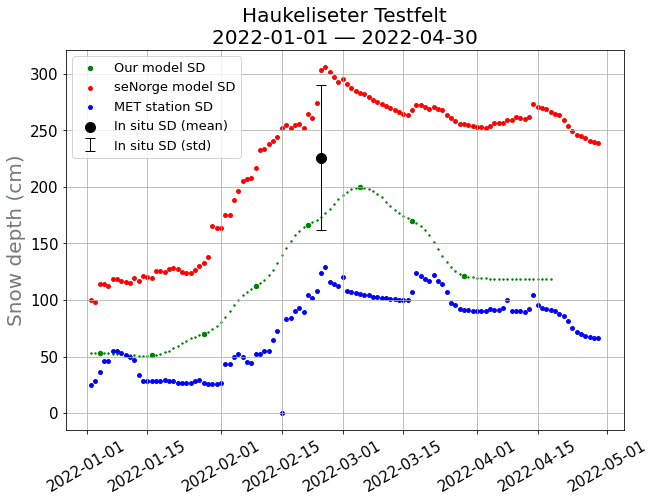

In [84]:
# Create template and choose window size
plt.figure(figsize = (10, 7))

# Generate title based on entered dates
plt.title(stationsnavn + '\n' + startdate +' ― ' + enddate, fontsize=20)

# Configure x-axis date labels
plt.xticks(rotation=30, fontsize=15)
myFmt = mdates.DateFormatter('%Y-%m-%d')
plt.gca().xaxis.set_major_formatter(myFmt)

# Configure y-axis labels
plt.yticks(fontsize = 15)
plt.ylabel('Snow depth (cm)',color='#71797E',fontsize = 20)

# Show grid
plt.grid(True)

# Generate plot
plt.scatter(mergedf2.Tid, mergedf2.SD_Model_smooth, color='green', s=2)
plt.scatter(mergedf2.Sample_Dat, mergedf2.SD_Model_smooth, color='green', s=20,  label='Our model SD')
plt.scatter(mergedf2.Tid, mergedf2.SD_SeNorge, color='red', s=15, label='seNorge model SD')
plt.scatter(mergedf2.Tid, mergedf2.SD_Station, color='blue', s=15, label='MET station SD')
plt.scatter(firsthand_obs.Tid, firsthand_obs.SD, color='black', s=100, label='In situ SD (mean)')
#plt.scatter(mergedf2.Tid, mergedf2.SD_Model, color='purple', s=10, label='SD_SeNorge')
plt.errorbar(firsthand_obs.Tid, firsthand_obs.SD,yerr=64, color='black',fmt='.',markersize=0.1,ecolor = 'black',animated=True, elinewidth=1,capsize=5,capthick=1, label='In situ SD (std)')
plt.legend(loc='upper left', prop={'size': 13})

fig_root = root + '\Figures'
plt.savefig(fig_root + '/' + stationsnavn + '.PNG', dpi = 600)

In [82]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
r2df = pd.DataFrame(mergedf2.dropna())
r2 = r2_score(r2df.SD_Station, r2df.SD_Model).round(2)
r2 = format(r2, '.2f')
print('r2', r2)
rms = mean_squared_error(r2df.SD_Station, r2df.SD_Model, squared=False).round(2)
print('RMSE_train: ', rms)

mae = mean_absolute_error(r2df.SD_Station, r2df.SD_Model).round(2)
print('MAE_train: ', mae)

r2 -1.66
RMSE_train:  55.55
MAE_train:  49.34


In [83]:
r2 = r2_score(r2df.SD_Station, r2df.SD_SeNorge).round(2)
r2 = format(r2, '.2f')
print('r2', r2)
rms = mean_squared_error(r2df.SD_Station, r2df.SD_SeNorge, squared=False).round(2)
print('RMSE_train: ', rms)

mae = mean_absolute_error(r2df.SD_Station, r2df.SD_SeNorge).round(2)
print('MAE_train: ', mae)

r2 -16.60
RMSE_train:  142.84
MAE_train:  137.99
